<a href="https://colab.research.google.com/github/sungjindo/black_coal_price/blob/main/Week_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0.Module

week기준 XGBoost로 trend 결과를 도출

In [3]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import os

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object
%matplotlib notebook
%matplotlib inline

# 통계 및 기계학습 관련 라이브러리
from scipy import stats    # 통계 관련 라이브러리
from sklearn.model_selection import train_test_split, RandomizedSearchCV    # 데이터 셋 분류 라이브러리
from sklearn.utils import resample    # 데이터 업샘플링&다운샘플링 라이브러리
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN    # 복합샘플링 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler    # 데이터 스케일링 라이브러리
from statsmodels.stats.outliers_influence import variance_inflation_factor    # 변수 간 다중공선성 확인(VIF) 라이브러리
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve)    # 모델 정확도 검증 라이브러리
from sklearn.model_selection import cross_val_score, train_test_split   # validation  검증 라이브러리

import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm    # 통계분석 관련 라이브러리
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet


import warnings    # 경고문구 지우기
warnings.filterwarnings("ignore")

# xgboost라이브러리 추가
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from datetime import datetime

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Mounted at /content/gdrive


In [23]:
# df = df.rename(columns ={  'Coal_price':'Coal',
#                             'iron':'iron',
#                              'Brent_fut':'Brent_fut',
#                              'copper_fut':'copper_fut',
#                              'WTI_fut':'WTI_fut',
#                              'WTI':'WTI',
#                              'LNG_fut':'LNG_fut',
#                              'bdi':'BDI',
#                             'USD/AUD(호주)':'AUD_dollar',
#                             'USD/CAD(캐나다)':'CAD_dollor',
#                             'USD/COP(콜롬비아)':'COP_dollor',
#                              'US 달러지수':'DXY',
#                              'USD/IDR(인도네시아)':'IDR_dollor',
#                              'USD/RUB(러시아)':'RUB_dollor',
#                              'USD/ZAR(자메이카)':'ZAR_dollor',
#                              '상하이종합지수':'SHA',
#                              '인도지수':'BSE',
#                              '브라질지수':'BVSP',
#                              '다우존스지수':'DJI',
#                              '프랑스지수':'CAC',
#                              '영국지수':'FTSE',
#                              '독일지수':'DAX',
#                              'S&P500지수':'S&P500',
#                              '항셍지수':'HSI',
#                              '나스닥지수':'IXIC',
#                              '코스피지수':'KOSPI',
#                              '니케이225지수':'Nikkei225',
#                              '유로스톡스50지수':'SX5E',
#                              '호주지수':'ASX',
#                              '캐나다지수':'TSX'
#                              })
# df

,Coal,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,CAD_dollor,...,FTSE,DAX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E,ASX,TSX
ds,,,,,,,,,,,,,,,,,,,,,
2011-01-01,122.65,168.30,94.75,9644.00,91.38,91.40,61.07,1773.0,0.984470,0.99960,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2011-01-02,122.65,168.30,94.75,9644.00,91.38,91.40,61.07,1773.0,0.984470,0.99960,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2011-01-03,136.50,170.00,94.84,9644.00,91.55,91.56,61.07,1773.0,0.979010,0.99270,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
2011-01-04,137.30,172.10,93.53,9619.25,89.38,89.23,58.32,1693.0,0.983370,0.99239,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
2011-01-05,130.65,174.50,95.50,9586.00,90.30,90.38,56.40,1621.0,0.992850,0.99700,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,79.85,155.02,51.29,7787.50,48.23,47.93,51.07,1366.0,1.314613,1.28482,...,6502.100098,13587.230469,3703.060059,26386.560547,12804.730469,2806.860107,26656.609375,3539.260010,6664.799805,17623.900391
2020-12-28,85.35,155.35,50.86,7787.50,47.62,47.87,51.07,1366.0,1.313730,1.28396,...,6502.100098,13790.290039,3735.360107,26314.630859,12899.419922,2808.600098,26854.029297,3575.409912,6664.799805,17623.900391
2020-12-29,84.20,155.57,51.09,7859.50,48.00,47.94,55.51,1366.0,1.317710,1.28400,...,6602.700195,13761.379883,3727.040039,26568.490234,12850.219727,2820.510010,27568.150391,3581.370117,6700.299805,17543.400391


#1.Data

In [39]:
df = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/usethis.csv")
df = df.sort_values('ds')

df['ds']= pd.to_datetime(df['ds'])

df = df.set_index('ds')
df = df[df.index < '2019-04-01']
df = df.resample('W-MON').mean() #월요일 기준으로 평균값 df

df = df.reset_index()
# df = df[['ds','Coal_price']]
df  

,ds,Coal,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,...,FTSE,DAX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E,ASX,TSX
0,2011-01-03,127.266667,168.866667,94.780000,9644.000000,91.436667,91.453333,61.070000,1773.000000,0.982650,...,5899.899902,6939.373372,1262.383341,23168.983073,2665.753418,2057.360026,10228.919922,2817.836670,4745.200195,13443.200195
1,2011-01-10,135.600000,173.442857,94.177143,9476.964286,88.771429,88.932857,56.531429,1558.571429,1.000303,...,5998.071289,6942.448521,1272.122855,23685.679129,2701.521380,2083.529994,10496.112723,2814.252825,4715.671387,13310.285575
2,2011-01-17,136.578571,177.857143,98.180000,9639.821429,91.504286,91.540000,55.690000,1446.714286,1.006029,...,6011.514369,7055.802874,1288.165702,24161.655971,2744.378627,2099.587123,10516.174247,2894.737130,4771.100098,13442.171177
3,2011-01-24,132.228571,178.500000,97.421429,9514.857143,89.471429,89.554286,55.398571,1384.428571,1.009414,...,5933.399902,7072.215681,1285.441424,24001.379464,2711.667201,2087.249930,10383.151228,2955.362898,4781.885812,13350.414062
4,2011-01-31,129.350000,179.371429,98.545714,9497.071429,88.481429,88.532857,54.164286,1175.714286,1.007243,...,5908.442871,7103.974191,1286.069999,23672.869699,2710.682826,2100.782889,10380.559989,2961.618513,4785.757045,13428.628348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,2019-03-04,96.414286,86.551429,65.501429,6458.821429,56.235714,56.052857,43.587143,659.857143,1.402134,...,7112.500140,11563.065569,2796.378523,28794.111328,7571.422782,2204.829973,21574.452567,3303.395787,6177.600028,16054.885603
427,2019-03-11,96.328571,85.577143,65.992857,6426.357143,56.348571,56.117143,42.027143,653.714286,1.419207,...,7140.071359,11520.452846,2760.362863,28566.744141,7469.460031,2153.005720,21282.981585,3302.278599,6214.342773,16047.128627
428,2019-03-18,94.214286,85.848571,67.210000,6435.142857,58.341429,58.272857,38.398571,698.428571,1.413800,...,7211.414272,11628.311523,2815.899972,29003.642578,7663.631348,2167.012870,21431.142578,3359.372872,6175.957241,16149.557338
429,2019-03-25,93.421429,85.825714,67.467143,6385.892857,59.254286,59.031429,36.681429,696.428571,1.407571,...,7252.957171,11483.059989,2816.024275,29103.176897,7693.918597,2177.901437,21520.545480,3338.064244,6175.585798,16133.442662


In [32]:
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns

#2.Graph


## XGboost - 19.01~03 (xfeature/week average)

In [33]:
import pandas as pd
import numpy as np
import re
from datetime import date, datetime
import datetime
from google.colab import drive
drive.mount('/content/gdrive/')

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgbm
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [40]:
period = 90

day_freq = 'D' #(day_freq를 'D'로하면 모든 날짜, 'B'로하면 주말 제외 주중만)


df = df.set_index('ds')

_ = pd.DataFrame({'weekly': 0}, index = pd.date_range(df.head(1).index[0], df.tail(1).index[0], freq=day_freq))
_ = pd.concat([df, _], axis = 1)
_
_ = _.dropna()
df = _.drop('weekly',axis = 1)
df

,Coal,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,CAD_dollor,...,FTSE,DAX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E,ASX,TSX
2011-01-03,127.266667,168.866667,94.780000,9644.000000,91.436667,91.453333,61.070000,1773.000000,0.982650,0.997300,...,5899.899902,6939.373372,1262.383341,23168.983073,2665.753418,2057.360026,10228.919922,2817.836670,4745.200195,13443.200195
2011-01-10,135.600000,173.442857,94.177143,9476.964286,88.771429,88.932857,56.531429,1558.571429,1.000303,0.995741,...,5998.071289,6942.448521,1272.122855,23685.679129,2701.521380,2083.529994,10496.112723,2814.252825,4715.671387,13310.285575
2011-01-17,136.578571,177.857143,98.180000,9639.821429,91.504286,91.540000,55.690000,1446.714286,1.006029,0.988957,...,6011.514369,7055.802874,1288.165702,24161.655971,2744.378627,2099.587123,10516.174247,2894.737130,4771.100098,13442.171177
2011-01-24,132.228571,178.500000,97.421429,9514.857143,89.471429,89.554286,55.398571,1384.428571,1.009414,0.994096,...,5933.399902,7072.215681,1285.441424,24001.379464,2711.667201,2087.249930,10383.151228,2955.362898,4781.885812,13350.414062
2011-01-31,129.350000,179.371429,98.545714,9497.071429,88.481429,88.532857,54.164286,1175.714286,1.007243,0.996093,...,5908.442871,7103.974191,1286.069999,23672.869699,2710.682826,2100.782889,10380.559989,2961.618513,4785.757045,13428.628348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-04,96.414286,86.551429,65.501429,6458.821429,56.235714,56.052857,43.587143,659.857143,1.402134,1.318124,...,7112.500140,11563.065569,2796.378523,28794.111328,7571.422782,2204.829973,21574.452567,3303.395787,6177.600028,16054.885603
2019-03-11,96.328571,85.577143,65.992857,6426.357143,56.348571,56.117143,42.027143,653.714286,1.419207,1.340861,...,7140.071359,11520.452846,2760.362863,28566.744141,7469.460031,2153.005720,21282.981585,3302.278599,6214.342773,16047.128627
2019-03-18,94.214286,85.848571,67.210000,6435.142857,58.341429,58.272857,38.398571,698.428571,1.413800,1.333739,...,7211.414272,11628.311523,2815.899972,29003.642578,7663.631348,2167.012870,21431.142578,3359.372872,6175.957241,16149.557338
2019-03-25,93.421429,85.825714,67.467143,6385.892857,59.254286,59.031429,36.681429,696.428571,1.407571,1.335214,...,7252.957171,11483.059989,2816.024275,29103.176897,7693.918597,2177.901437,21520.545480,3338.064244,6175.585798,16133.442662


In [41]:
index = df.index
col_names = df.columns

In [42]:
train_end_time = datetime.date(2018, 12, 31)
test_end_time = train_end_time+ datetime.timedelta(period)
train_end_time = f'{train_end_time.year}-{train_end_time.month}-{train_end_time.day}'
test_end_time = f'{test_end_time.year}-{test_end_time.month}-{test_end_time.day}'
test_end_time = pd.date_range(train_end_time,test_end_time, freq=day_freq)

df = df.loc[df.index <= test_end_time[-1]].copy()

In [43]:
df

,Coal,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,CAD_dollor,...,FTSE,DAX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E,ASX,TSX
2011-01-03,127.266667,168.866667,94.780000,9644.000000,91.436667,91.453333,61.070000,1773.000000,0.982650,0.997300,...,5899.899902,6939.373372,1262.383341,23168.983073,2665.753418,2057.360026,10228.919922,2817.836670,4745.200195,13443.200195
2011-01-10,135.600000,173.442857,94.177143,9476.964286,88.771429,88.932857,56.531429,1558.571429,1.000303,0.995741,...,5998.071289,6942.448521,1272.122855,23685.679129,2701.521380,2083.529994,10496.112723,2814.252825,4715.671387,13310.285575
2011-01-17,136.578571,177.857143,98.180000,9639.821429,91.504286,91.540000,55.690000,1446.714286,1.006029,0.988957,...,6011.514369,7055.802874,1288.165702,24161.655971,2744.378627,2099.587123,10516.174247,2894.737130,4771.100098,13442.171177
2011-01-24,132.228571,178.500000,97.421429,9514.857143,89.471429,89.554286,55.398571,1384.428571,1.009414,0.994096,...,5933.399902,7072.215681,1285.441424,24001.379464,2711.667201,2087.249930,10383.151228,2955.362898,4781.885812,13350.414062
2011-01-31,129.350000,179.371429,98.545714,9497.071429,88.481429,88.532857,54.164286,1175.714286,1.007243,0.996093,...,5908.442871,7103.974191,1286.069999,23672.869699,2710.682826,2100.782889,10380.559989,2961.618513,4785.757045,13428.628348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-25,94.921429,88.205714,66.674286,6435.285714,56.747143,56.411429,45.455714,632.285714,1.401286,1.320287,...,7184.957241,11430.421456,2787.637102,28682.900670,7510.375698,2226.872838,21429.018694,3264.894287,6147.257045,16009.357282
2019-03-04,96.414286,86.551429,65.501429,6458.821429,56.235714,56.052857,43.587143,659.857143,1.402134,1.318124,...,7112.500140,11563.065569,2796.378523,28794.111328,7571.422782,2204.829973,21574.452567,3303.395787,6177.600028,16054.885603
2019-03-11,96.328571,85.577143,65.992857,6426.357143,56.348571,56.117143,42.027143,653.714286,1.419207,1.340861,...,7140.071359,11520.452846,2760.362863,28566.744141,7469.460031,2153.005720,21282.981585,3302.278599,6214.342773,16047.128627
2019-03-18,94.214286,85.848571,67.210000,6435.142857,58.341429,58.272857,38.398571,698.428571,1.413800,1.333739,...,7211.414272,11628.311523,2815.899972,29003.642578,7663.631348,2167.012870,21431.142578,3359.372872,6175.957241,16149.557338


In [47]:
def create_features(df, col_name):
    X = df[col_name].drop(df.tail(1).index)
    y = df[col_name].shift(-1).drop(df.tail(1).index).rename("shift")
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    return X, y

In [ ]:


# params = {'objective': 'regression', 
#           'num_leaves': 5, 
#           'learning_rate': 0.1, 
#           'max_depth': 10,  
#           #'max_bin': 55, 
#           #'bagging_fraction': 0.8, 
#           #'bagging_freq': 5,
#           #'feature_fraction': 0.8, 
#           #'feature_fraction_seed': 9,
#           #'bagging_seed': 9, 
#           #'min_data_in_leaf': 6, 
#           #'min_sum_hessian_in_leaf': 11
#           }

In [49]:

final_df = df[['Coal']]
true_df = pd.DataFrame()
for k in range(1,len(col_names)):
  df_X, df_y = create_features(df, col_names[k])
  df_y_rate = pd.DataFrame({"y_rate" : (df_y['shift']-df_X[col_names[k]])}, index = df_y.index)
  test_split_date = '2018-12-31'
  #val_split_date = '2017-12-31'
  
  
  train_X = df_X.loc[df_X.index < test_split_date].copy()
  #val_X = train_X.loc[train_X.index > val_split_date].copy()
  #train_X = train_X.loc[train_X.index <= val_split_date].copy()
  test_X = df_X.loc[df_X.index >= test_split_date].copy()

  train_y_rate = df_y_rate.loc[df_y_rate.index < test_split_date].copy()
  #val_y_rate = train_y_rate.loc[train_y_rate.index > val_split_date].copy()
  #train_y_rate = train_y_rate.loc[train_y_rate.index <= val_split_date].copy()
  test_y_rate = df_y_rate.loc[df_y_rate.index >= test_split_date].copy()

  train_y = df_y.loc[df_y.index < test_split_date].copy()
  test_y = df_y.loc[df_y.index >= test_split_date].copy()

  # split_date = '2018-12-31'
  # train_X = df_X.loc[df_X.index < split_date].copy()
  # test_X = df_X.loc[df_X.index >= split_date].copy()
  # train_y_rate = df_y_rate.loc[df_y_rate.index < split_date].copy()
  # test_y_rate = df_y_rate.loc[df_y_rate.index >= split_date].copy()
  # train_y = df_y.loc[df_y.index < split_date].copy()
  # test_y = df_y.loc[df_y.index >= split_date].copy()




  reg = xgb.XGBRegressor(num_round = 200, learning_rate=0.6,max_depth=1,n_estimators=90)
  reg.fit(train_X, train_y_rate,
          #eval_set=[(train_X, train_y_rate), (train_X, train_y_rate)],
          #early_stopping_rounds=100,
          verbose=False)
  

  df_y_pred = test_X.head(1)
  for i in range(len(test_end_time)):
    y_pred = reg.predict(df_y_pred.tail(1))
    y_pred = y_pred+df_y_pred[col_names[k]].tail(1)
    _ = df_y_pred.tail(1).index+datetime.timedelta(days=1)
    _ = pd.date_range(_[0],periods = 1, freq = day_freq)
    frame = pd.DataFrame({col_names[k]:y_pred[0]},index = _)
    frame
    df_y_pred = df_y_pred.append(frame)
    _ = pd.concat([train_X, df_y_pred])
  final_df = pd.concat([final_df, _], axis=1)
  true_df = pd.concat([true_df, test_X], axis=1)

[02:36:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:36:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:36:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:36:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:36:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:36:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:36:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:36:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

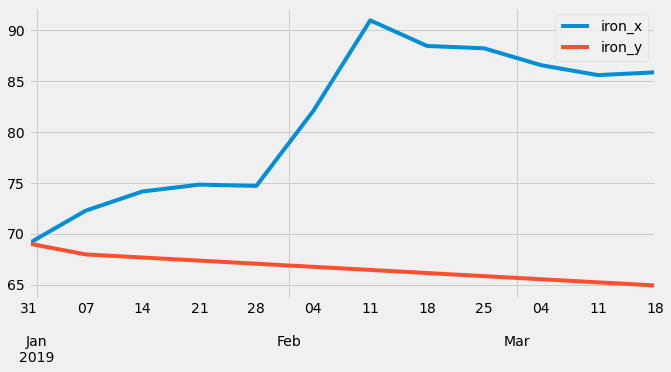

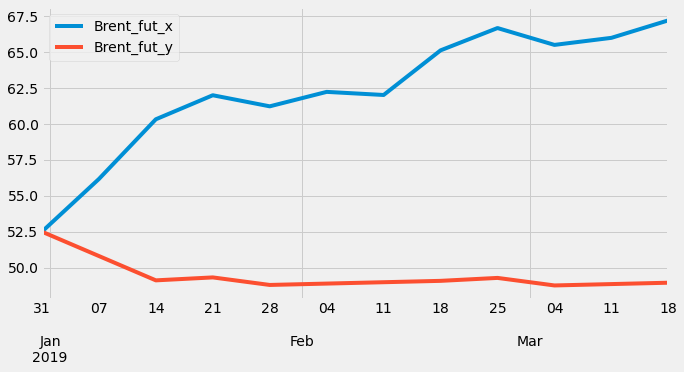

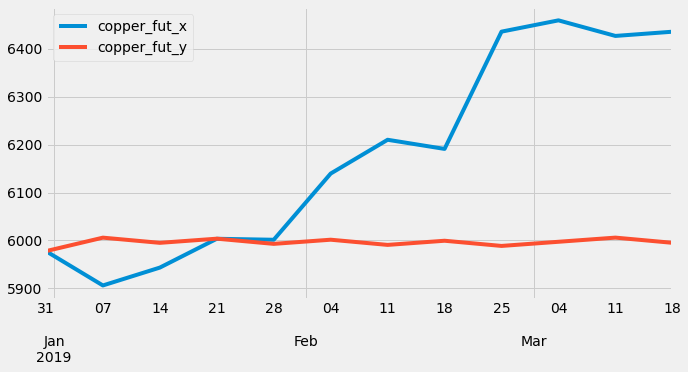

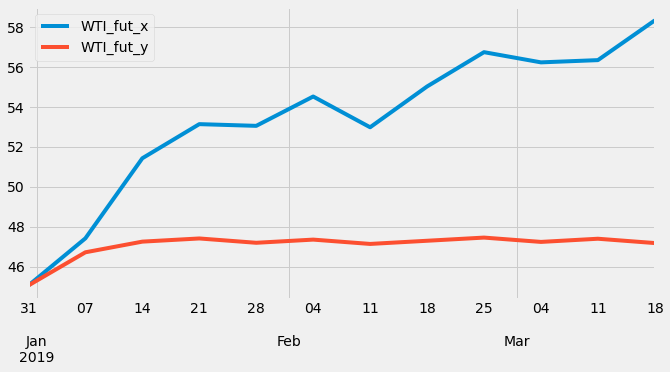

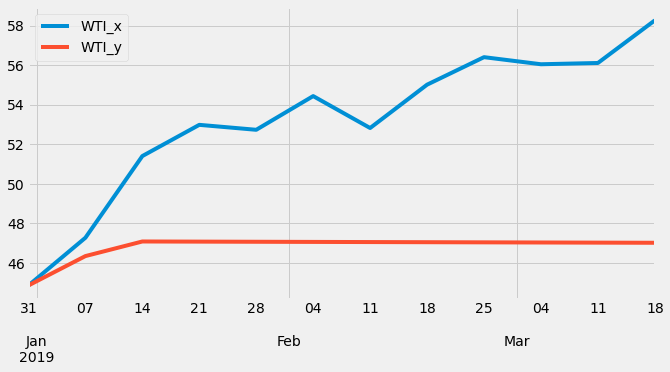

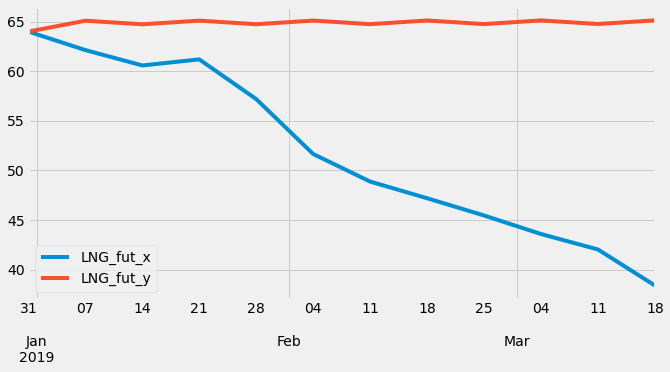

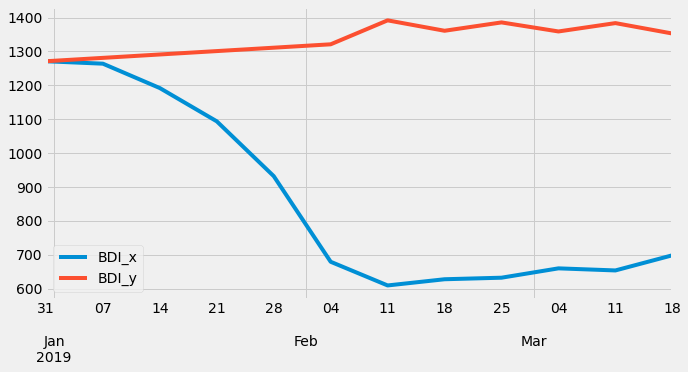

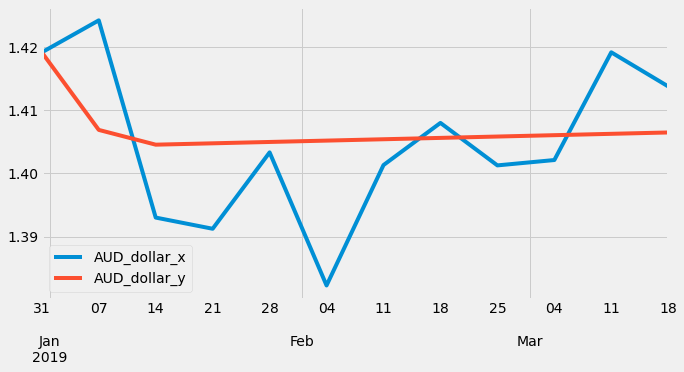

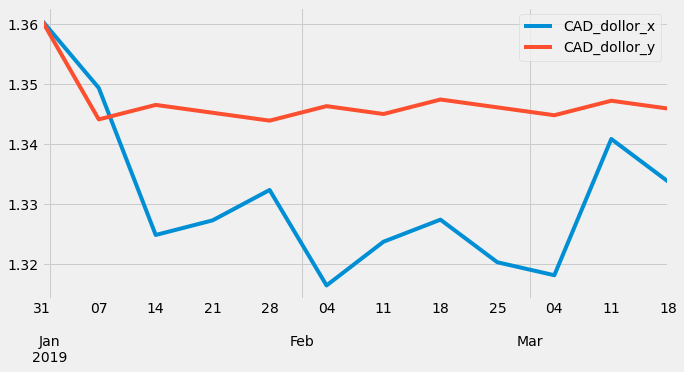

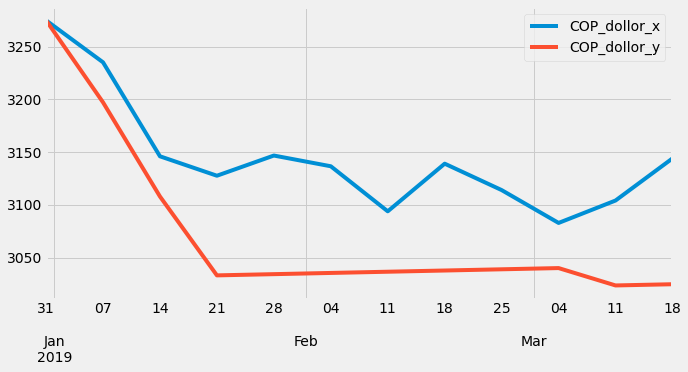

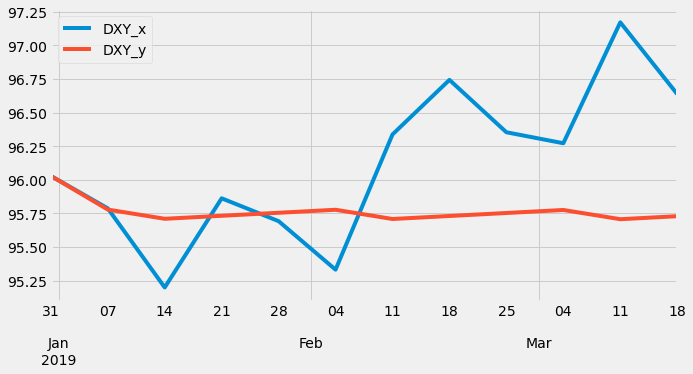

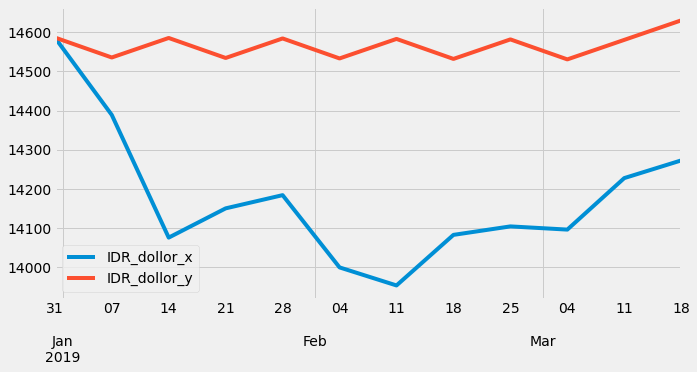

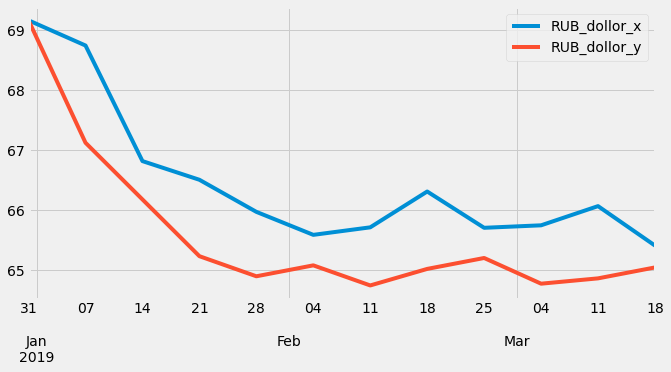

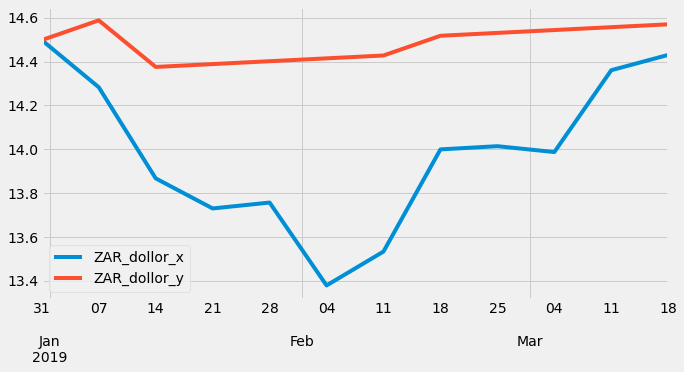

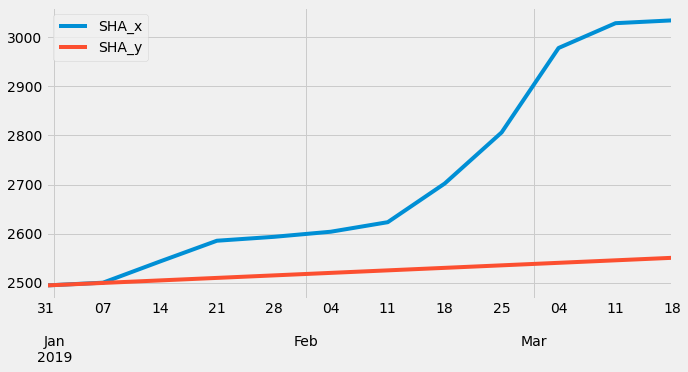

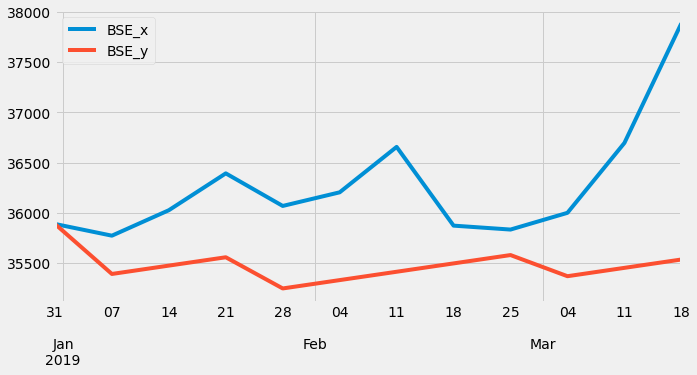

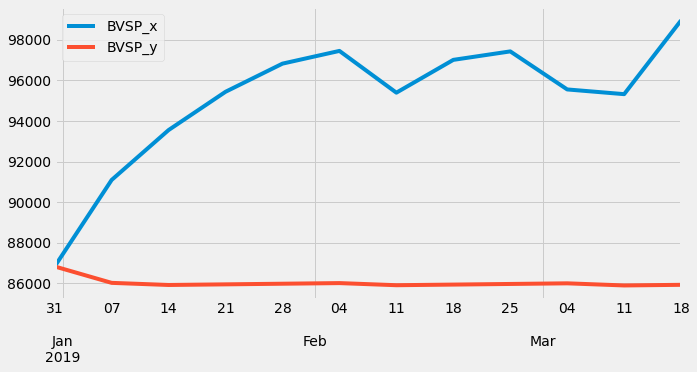

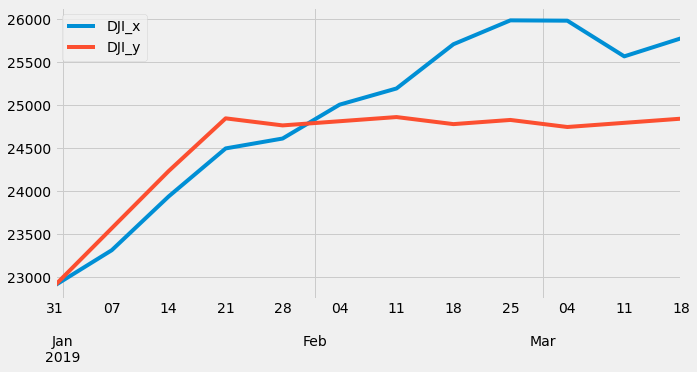

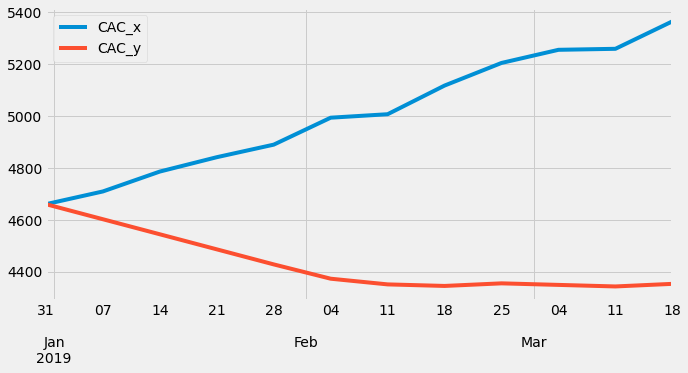

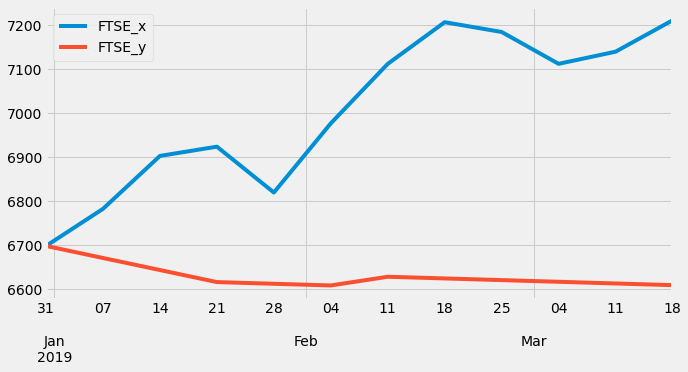

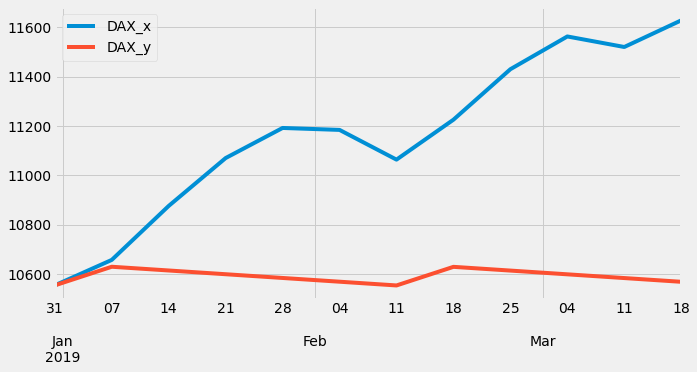

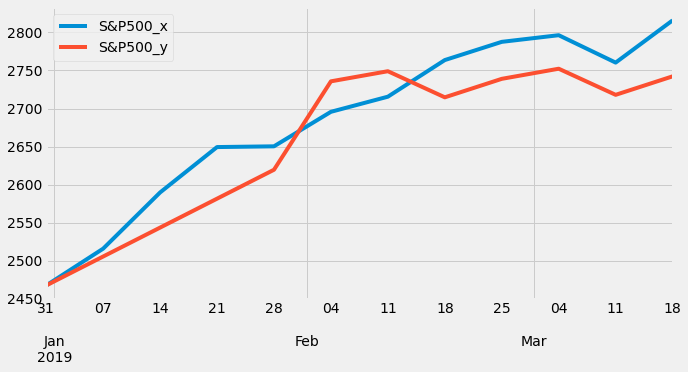

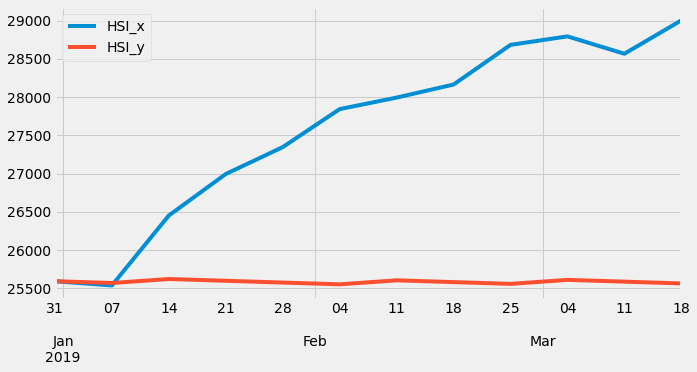

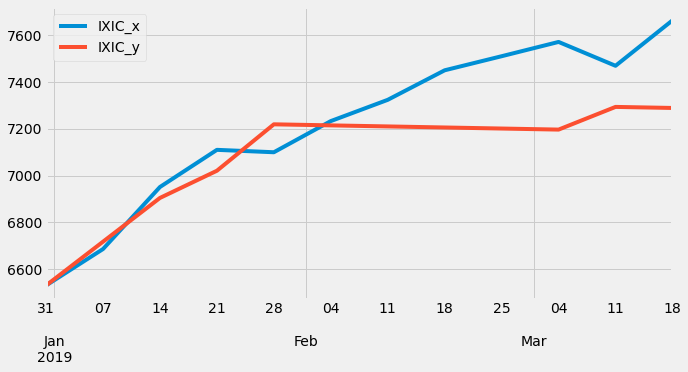

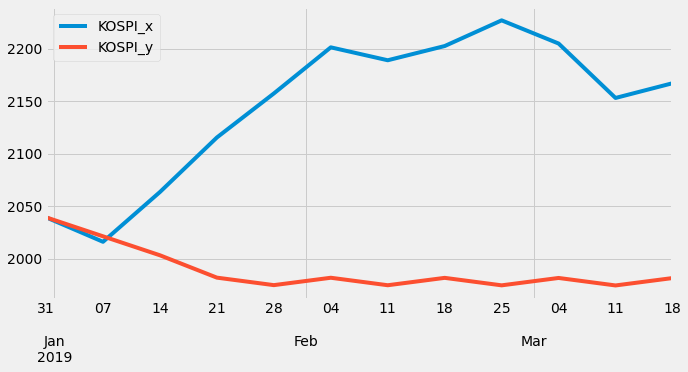

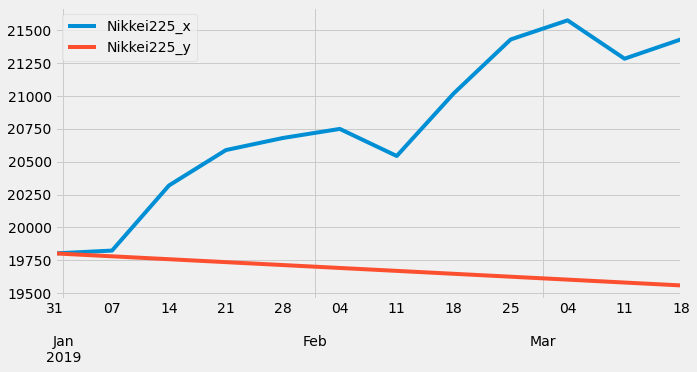

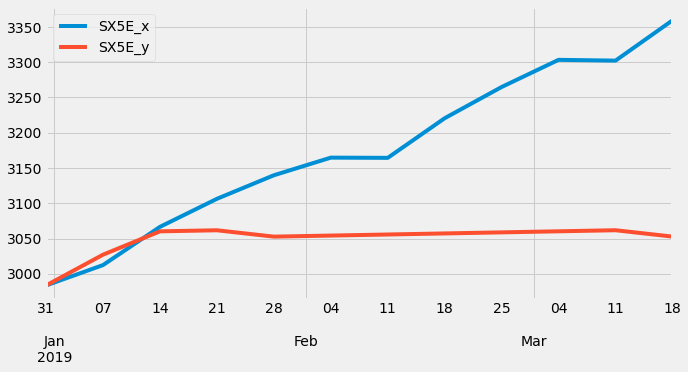

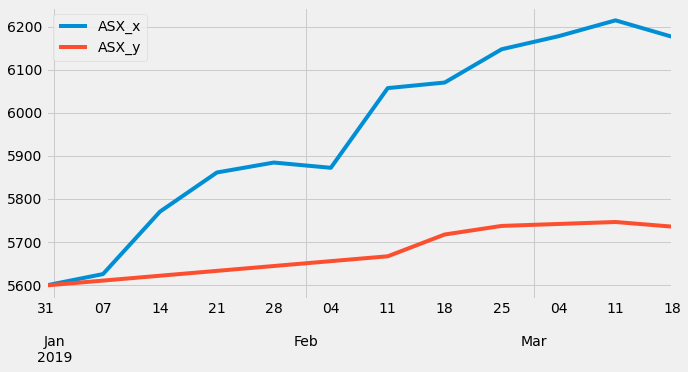

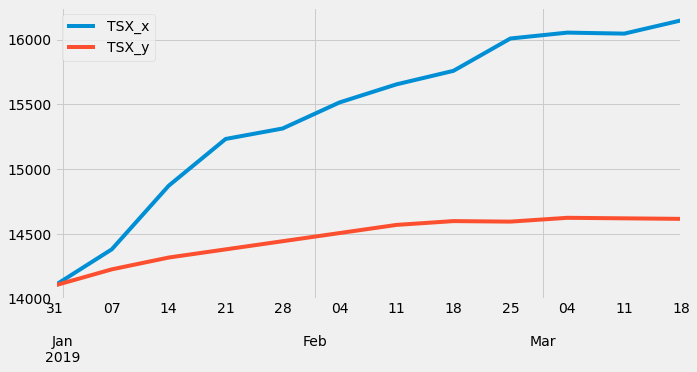

In [50]:
for i in range(1, len(col_names)):
  _ = pd.merge(true_df[col_names[i]], final_df[col_names[i]], how = 'left', left_index = True, right_index=True)
  _ = _.plot(figsize=(10, 5))

In [53]:
final_df = final_df[final_df.index >= '2019-01-01']

df = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/usethis.csv")
df = df.sort_values('ds')

df['ds']= pd.to_datetime(df['ds'])

df = df.set_index('ds')
df = df[df.index <= '2019-04-01']
 #월요일 기준으로 평균값 df

df[df.index >= '2019-01-01']
final_df['Coal']=df[df.index >= '2019-01-01']['Coal']
df[df.index >= '2019-01-01']=final_df
df

,Coal,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,CAD_dollor,...,FTSE,DAX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E,ASX,TSX
2019-01-01,NaN,68.632955,52.258018,5981.837280,45.293030,45.079238,64.469744,1272.429153,1.409647,1.362362,...,6694.197634,10591.619710,2472.818005,25620.396881,6557.515412,2036.793306,19799.620960,2989.759455,5600.767912,14124.046542
2019-01-02,NaN,68.205909,52.016036,5985.853132,45.530346,45.291334,64.939489,1273.858306,1.407487,1.357701,...,6690.280941,10628.240815,2478.250267,25574.044308,6584.229414,2034.212310,19796.456485,2995.990276,5602.378806,14146.021515
2019-01-03,NaN,68.162406,51.774053,5989.868983,45.767661,45.503429,64.679317,1275.287460,1.405326,1.352528,...,6686.364248,10574.364129,2483.682529,25603.021267,6610.943417,2031.631314,19793.292010,3002.221098,5603.989701,14162.090560
2019-01-04,NaN,68.118902,51.532071,5993.884835,46.004977,45.715524,65.149062,1276.716613,1.405722,1.347356,...,6682.447555,10610.985234,2489.114792,25556.668694,6637.657419,2029.050317,19790.127535,3008.451919,5605.600595,14178.159604
2019-01-05,NaN,68.075399,51.290089,5997.900686,46.242293,45.927620,64.888891,1278.145766,1.406118,1.345036,...,6678.530862,10557.108548,2494.547054,25585.645653,6664.371422,2026.469321,19786.963060,3014.682740,5607.211490,14194.228648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-28,NaN,64.508110,49.266603,5996.434099,47.299629,47.280861,64.722406,1391.134794,1.405350,1.345122,...,6616.939012,10573.612062,2740.364430,25551.211266,7268.316765,1981.495530,19572.844804,3062.469387,5731.116555,14605.720991
2019-03-29,NaN,64.464606,49.024621,6000.449950,47.161382,47.119967,65.192150,1353.374541,1.405746,1.346534,...,6613.022318,10610.233167,2747.497619,25580.188225,7296.658530,1974.412680,19569.680329,3058.174283,5738.343823,14614.721491
2019-03-30,NaN,64.421103,48.892592,6004.465802,47.398698,46.959072,64.931979,1375.027172,1.406142,1.344213,...,6609.105625,10556.356481,2696.016628,25609.165184,7223.549704,1981.481351,19566.515854,3053.879180,5745.571090,14623.721992
2019-03-31,NaN,64.377599,48.760562,5989.024805,47.260451,47.171167,64.671808,1396.679804,1.406538,1.345625,...,6628.786841,10592.977586,2714.142774,25562.812611,7251.891468,1974.398501,19563.351379,3060.110001,5737.449824,14599.180677


In [62]:
df.to_csv("/content/gdrive/MyDrive/Black_coal/data/XGB_week_pred.csv",encoding = 'utf-8-sig',index= True)

#3.Graph


## XGboost - 19.01~03 (xfeature/month average)

In [98]:
df = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/usethis.csv")
df = df.sort_values('ds')

df['ds']= pd.to_datetime(df['ds'])

df = df.set_index('ds')
df = df[df.index < '2019-04-01']
df = df.resample('M').mean() #M 기준으로 평균값 df

df = df.reset_index()
# df = df[['ds','Coal_price']]
df  

,ds,Coal,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,...,FTSE,DAX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E,ASX,TSX
0,2011-01-31,132.841935,176.477419,96.858387,9543.000000,89.739032,89.815484,55.990323,1428.290323,1.003512,...,5956.764475,7033.522870,1280.959673,23811.549647,2712.097113,2089.359021,10423.185389,2897.913212,4761.822612,13388.712733
1,2011-02-28,126.314286,186.571429,104.017143,9907.687500,89.596429,89.662500,53.643214,1184.357143,0.991758,...,6025.296387,7295.781791,1323.216784,23287.490025,2789.593209,2011.301793,10623.792132,3016.993931,4874.167882,13923.132080
2,2011-03-31,127.170968,169.441935,114.713226,9518.491935,102.989355,103.018065,60.478065,1496.548387,0.991232,...,5857.587072,6950.227728,1304.518385,23089.378906,2722.150651,1999.638715,9849.758348,2888.781628,4716.728988,13934.480658
3,2011-04-30,122.733333,178.203333,123.242333,9495.141667,110.411667,110.404667,59.495667,1336.800000,0.946827,...,6015.929915,7238.686393,1332.212349,24033.355273,2798.159969,2152.758000,9669.745931,2949.525008,4887.526644,13979.459993
4,2011-05-31,120.969355,168.451613,114.391290,8967.419355,101.188065,101.128387,57.223548,1354.774194,0.935895,...,5948.974153,7336.755812,1338.190634,23191.691784,2816.110021,2126.069332,9693.587450,2887.175151,4715.293567,13626.454763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,2018-11-30,103.280000,74.268667,66.267333,6175.541667,56.833333,56.787667,68.244000,1189.333333,1.380844,...,7041.013298,11369.181120,2719.453003,26072.690560,7227.714697,2083.242334,21953.782096,3187.485653,5783.570020,15142.930046
95,2018-12-31,101.969355,68.238387,57.332903,6079.266129,48.843226,48.718710,66.017419,1316.935484,1.393281,...,6790.854902,10801.788401,2568.423245,26018.887979,6808.993920,2068.308405,20998.966293,3055.964860,5608.503213,14498.077369
96,2019-01-31,99.143548,74.160000,60.092258,5978.903226,51.503871,51.355484,59.628710,1082.451613,1.401736,...,6862.880670,10972.885238,2608.389995,26690.538117,6981.617392,2098.720991,20383.107170,3088.722255,5794.112935,15003.090190
97,2019-02-28,96.142857,88.676786,64.466786,6283.553571,55.117857,54.970714,47.297143,629.035714,1.398658,...,7141.417969,11260.950370,2752.977853,28279.619629,7420.282889,2207.069999,21020.633789,3217.803964,6066.003523,15794.025042


In [99]:
period = 90

day_freq = 'D' #(day_freq를 'D'로하면 모든 날짜, 'B'로하면 주말 제외 주중만)


df = df.set_index('ds')

_ = pd.DataFrame({'Monthly': 0}, index = pd.date_range(df.head(1).index[0], df.tail(1).index[0], freq=day_freq))
_ = pd.concat([df, _], axis = 1)
_
_ = _.dropna()
df = _.drop('Monthly',axis = 1)
df

,Coal,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,CAD_dollor,...,FTSE,DAX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E,ASX,TSX
2011-01-31,132.841935,176.477419,96.858387,9543.000000,89.739032,89.815484,55.990323,1428.290323,1.003512,0.994068,...,5956.764475,7033.522870,1280.959673,23811.549647,2712.097113,2089.359021,10423.185389,2897.913212,4761.822612,13388.712733
2011-02-28,126.314286,186.571429,104.017143,9907.687500,89.596429,89.662500,53.643214,1184.357143,0.991758,0.988415,...,6025.296387,7295.781791,1323.216784,23287.490025,2789.593209,2011.301793,10623.792132,3016.993931,4874.167882,13923.132080
2011-03-31,127.170968,169.441935,114.713226,9518.491935,102.989355,103.018065,60.478065,1496.548387,0.991232,0.976775,...,5857.587072,6950.227728,1304.518385,23089.378906,2722.150651,1999.638715,9849.758348,2888.781628,4716.728988,13934.480658
2011-04-30,122.733333,178.203333,123.242333,9495.141667,110.411667,110.404667,59.495667,1336.800000,0.946827,0.958769,...,6015.929915,7238.686393,1332.212349,24033.355273,2798.159969,2152.758000,9669.745931,2949.525008,4887.526644,13979.459993
2011-05-31,120.969355,168.451613,114.391290,8967.419355,101.188065,101.128387,57.223548,1354.774194,0.935895,0.966804,...,5948.974153,7336.755812,1338.190634,23191.691784,2816.110021,2126.069332,9693.587450,2887.175151,4715.293567,13626.454763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-30,103.280000,74.268667,66.267333,6175.541667,56.833333,56.787667,68.244000,1189.333333,1.380844,1.318222,...,7041.013298,11369.181120,2719.453003,26072.690560,7227.714697,2083.242334,21953.782096,3187.485653,5783.570020,15142.930046
2018-12-31,101.969355,68.238387,57.332903,6079.266129,48.843226,48.718710,66.017419,1316.935484,1.393281,1.343093,...,6790.854902,10801.788401,2568.423245,26018.887979,6808.993920,2068.308405,20998.966293,3055.964860,5608.503213,14498.077369
2019-01-31,99.143548,74.160000,60.092258,5978.903226,51.503871,51.355484,59.628710,1082.451613,1.401736,1.332396,...,6862.880670,10972.885238,2608.389995,26690.538117,6981.617392,2098.720991,20383.107170,3088.722255,5794.112935,15003.090190
2019-02-28,96.142857,88.676786,64.466786,6283.553571,55.117857,54.970714,47.297143,629.035714,1.398658,1.321310,...,7141.417969,11260.950370,2752.977853,28279.619629,7420.282889,2207.069999,21020.633789,3217.803964,6066.003523,15794.025042


In [100]:
index = df.index
col_names = df.columns

In [101]:
train_end_time = datetime.date(2018, 12, 31)
test_end_time = train_end_time+ datetime.timedelta(period)
train_end_time = f'{train_end_time.year}-{train_end_time.month}-{train_end_time.day}'
test_end_time = f'{test_end_time.year}-{test_end_time.month}-{test_end_time.day}'
test_end_time = pd.date_range(train_end_time,test_end_time, freq=day_freq)

df = df.loc[df.index <= test_end_time[-1]].copy()

In [102]:
df

,Coal,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,CAD_dollor,...,FTSE,DAX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E,ASX,TSX
2011-01-31,132.841935,176.477419,96.858387,9543.000000,89.739032,89.815484,55.990323,1428.290323,1.003512,0.994068,...,5956.764475,7033.522870,1280.959673,23811.549647,2712.097113,2089.359021,10423.185389,2897.913212,4761.822612,13388.712733
2011-02-28,126.314286,186.571429,104.017143,9907.687500,89.596429,89.662500,53.643214,1184.357143,0.991758,0.988415,...,6025.296387,7295.781791,1323.216784,23287.490025,2789.593209,2011.301793,10623.792132,3016.993931,4874.167882,13923.132080
2011-03-31,127.170968,169.441935,114.713226,9518.491935,102.989355,103.018065,60.478065,1496.548387,0.991232,0.976775,...,5857.587072,6950.227728,1304.518385,23089.378906,2722.150651,1999.638715,9849.758348,2888.781628,4716.728988,13934.480658
2011-04-30,122.733333,178.203333,123.242333,9495.141667,110.411667,110.404667,59.495667,1336.800000,0.946827,0.958769,...,6015.929915,7238.686393,1332.212349,24033.355273,2798.159969,2152.758000,9669.745931,2949.525008,4887.526644,13979.459993
2011-05-31,120.969355,168.451613,114.391290,8967.419355,101.188065,101.128387,57.223548,1354.774194,0.935895,0.966804,...,5948.974153,7336.755812,1338.190634,23191.691784,2816.110021,2126.069332,9693.587450,2887.175151,4715.293567,13626.454763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-30,103.280000,74.268667,66.267333,6175.541667,56.833333,56.787667,68.244000,1189.333333,1.380844,1.318222,...,7041.013298,11369.181120,2719.453003,26072.690560,7227.714697,2083.242334,21953.782096,3187.485653,5783.570020,15142.930046
2018-12-31,101.969355,68.238387,57.332903,6079.266129,48.843226,48.718710,66.017419,1316.935484,1.393281,1.343093,...,6790.854902,10801.788401,2568.423245,26018.887979,6808.993920,2068.308405,20998.966293,3055.964860,5608.503213,14498.077369
2019-01-31,99.143548,74.160000,60.092258,5978.903226,51.503871,51.355484,59.628710,1082.451613,1.401736,1.332396,...,6862.880670,10972.885238,2608.389995,26690.538117,6981.617392,2098.720991,20383.107170,3088.722255,5794.112935,15003.090190
2019-02-28,96.142857,88.676786,64.466786,6283.553571,55.117857,54.970714,47.297143,629.035714,1.398658,1.321310,...,7141.417969,11260.950370,2752.977853,28279.619629,7420.282889,2207.069999,21020.633789,3217.803964,6066.003523,15794.025042


In [103]:
def create_features(df, col_name):
    X = df[col_name].drop(df.tail(1).index)
    y = df[col_name].shift(-1).drop(df.tail(1).index).rename("shift")
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    return X, y

In [95]:


# params = {'objective': 'regression', 
#           'num_leaves': 5, 
#           'learning_rate': 0.1, 
#           'max_depth': 10,  
#           #'max_bin': 55, 
#           #'bagging_fraction': 0.8, 
#           #'bagging_freq': 5,
#           #'feature_fraction': 0.8, 
#           #'feature_fraction_seed': 9,
#           #'bagging_seed': 9, 
#           #'min_data_in_leaf': 6, 
#           #'min_sum_hessian_in_leaf': 11
#           }

In [104]:

final_df = df[['Coal']]
true_df = pd.DataFrame()
for k in range(1,len(col_names)):
  df_X, df_y = create_features(df, col_names[k])
  df_y_rate = pd.DataFrame({"y_rate" : (df_y['shift']-df_X[col_names[k]])}, index = df_y.index)
  test_split_date = '2018-12-31'
  #val_split_date = '2017-12-31'
  
  
  train_X = df_X.loc[df_X.index < test_split_date].copy()
  #val_X = train_X.loc[train_X.index > val_split_date].copy()
  #train_X = train_X.loc[train_X.index <= val_split_date].copy()
  test_X = df_X.loc[df_X.index >= test_split_date].copy()

  train_y_rate = df_y_rate.loc[df_y_rate.index < test_split_date].copy()
  #val_y_rate = train_y_rate.loc[train_y_rate.index > val_split_date].copy()
  #train_y_rate = train_y_rate.loc[train_y_rate.index <= val_split_date].copy()
  test_y_rate = df_y_rate.loc[df_y_rate.index >= test_split_date].copy()

  train_y = df_y.loc[df_y.index < test_split_date].copy()
  test_y = df_y.loc[df_y.index >= test_split_date].copy()

  # split_date = '2018-12-31'
  # train_X = df_X.loc[df_X.index < split_date].copy()
  # test_X = df_X.loc[df_X.index >= split_date].copy()
  # train_y_rate = df_y_rate.loc[df_y_rate.index < split_date].copy()
  # test_y_rate = df_y_rate.loc[df_y_rate.index >= split_date].copy()
  # train_y = df_y.loc[df_y.index < split_date].copy()
  # test_y = df_y.loc[df_y.index >= split_date].copy()




  reg = xgb.XGBRegressor(num_round = 200, learning_rate=0.6,max_depth=1,n_estimators=90)
  reg.fit(train_X, train_y_rate,
          #eval_set=[(train_X, train_y_rate), (train_X, train_y_rate)],
          #early_stopping_rounds=100,
          verbose=False)
  

  df_y_pred = test_X.head(1)
  for i in range(len(test_end_time)):
    y_pred = reg.predict(df_y_pred.tail(1))
    y_pred = y_pred+df_y_pred[col_names[k]].tail(1)
    _ = df_y_pred.tail(1).index+datetime.timedelta(days=1)
    _ = pd.date_range(_[0],periods = 1, freq = day_freq)
    frame = pd.DataFrame({col_names[k]:y_pred[0]},index = _)
    frame
    df_y_pred = df_y_pred.append(frame)
    _ = pd.concat([train_X, df_y_pred])
  final_df = pd.concat([final_df, _], axis=1)
  true_df = pd.concat([true_df, test_X], axis=1)

[05:35:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:35:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:35:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:35:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:35:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:35:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:35:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:36:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

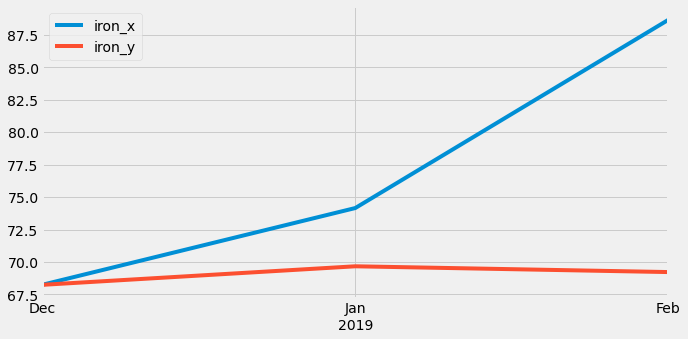

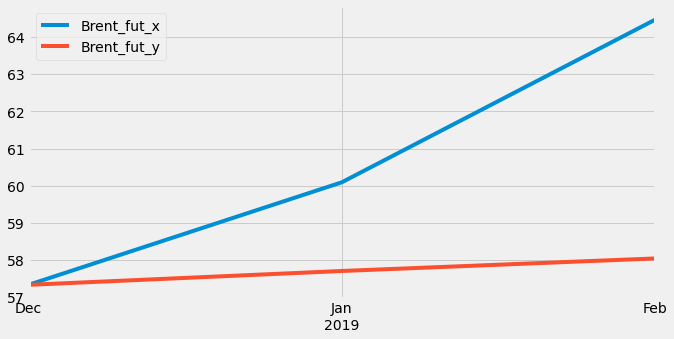

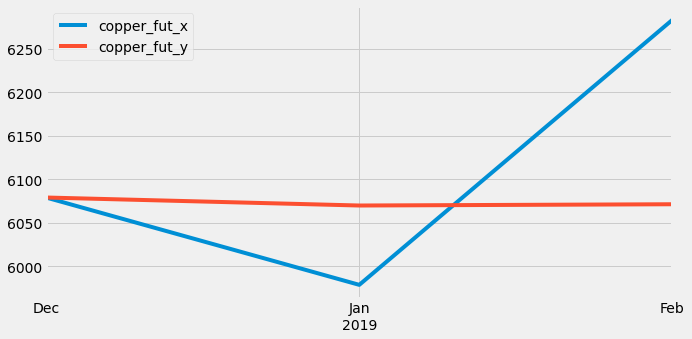

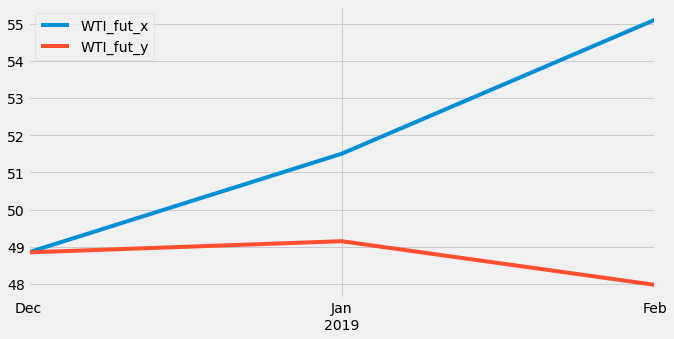

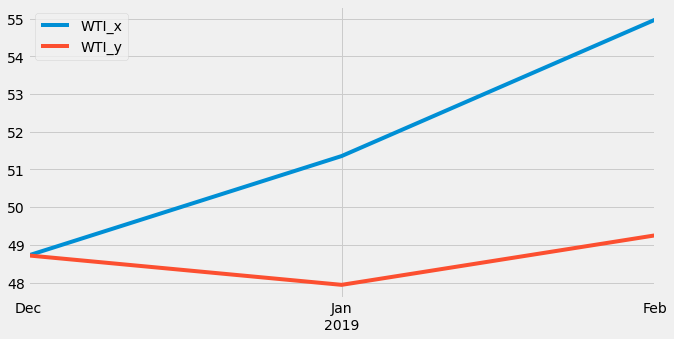

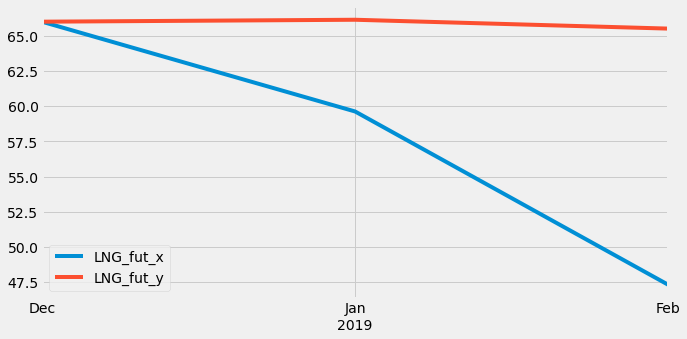

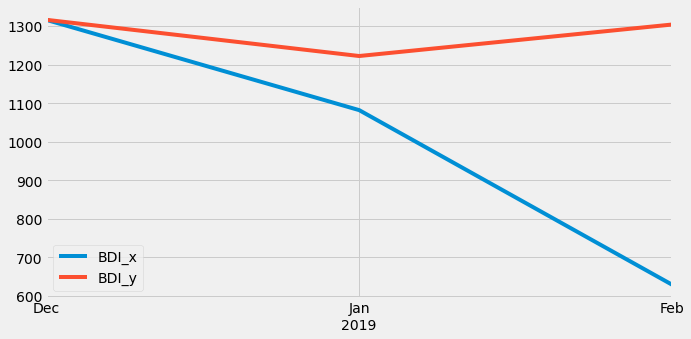

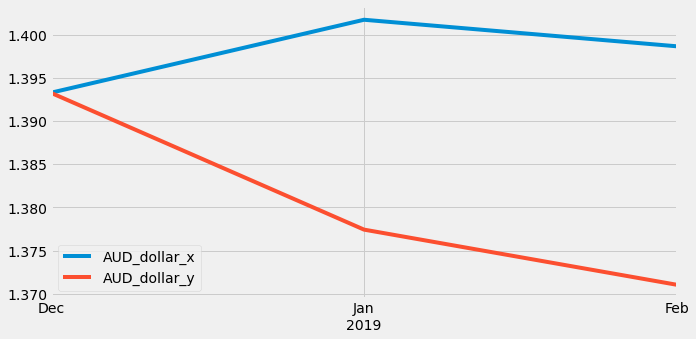

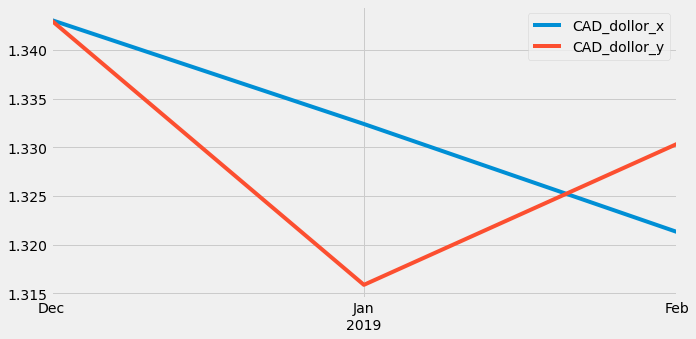

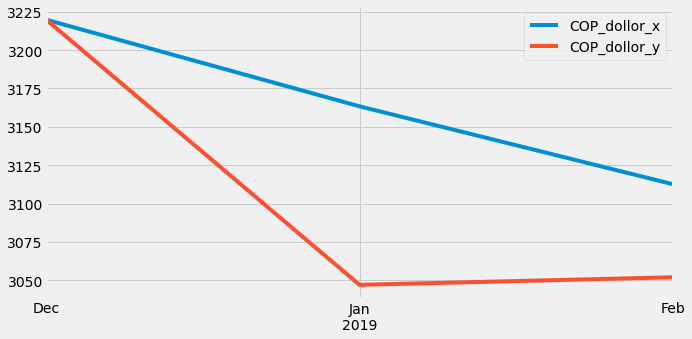

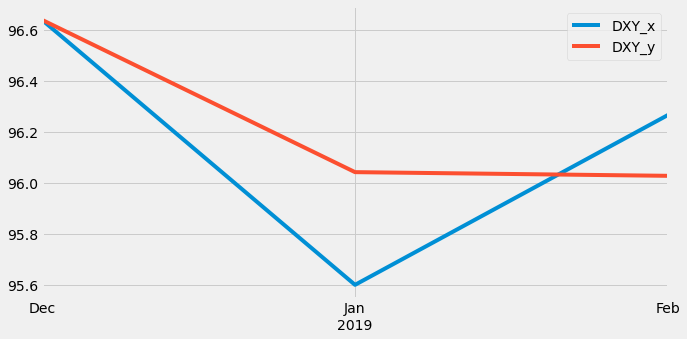

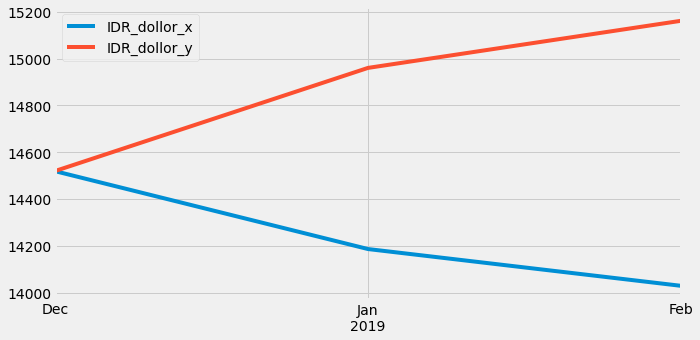

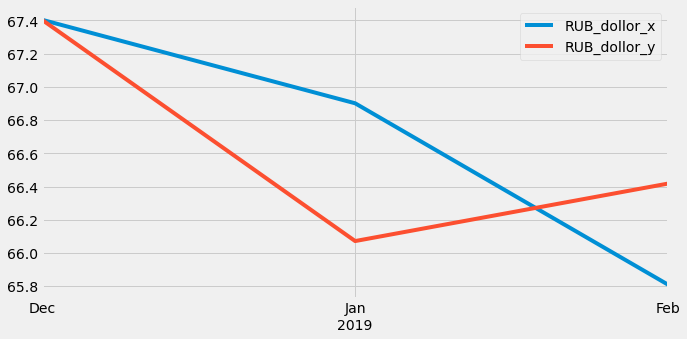

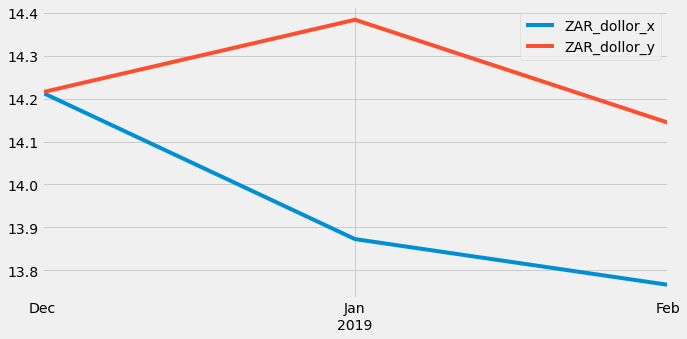

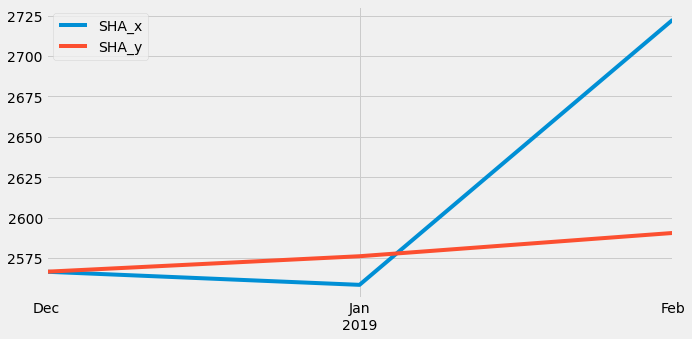

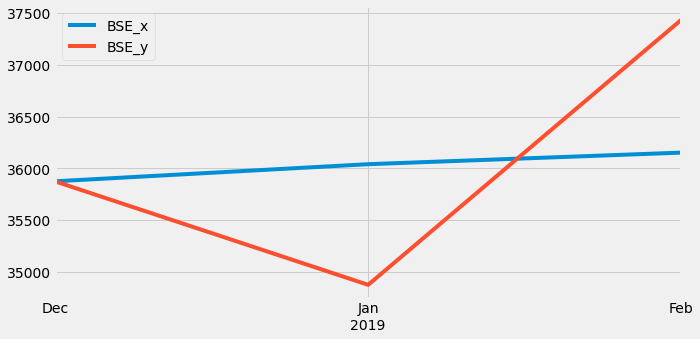

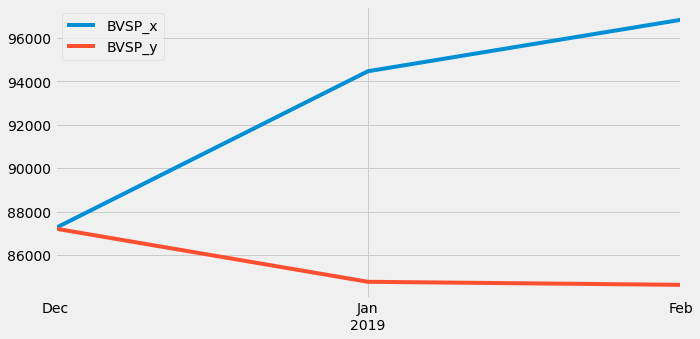

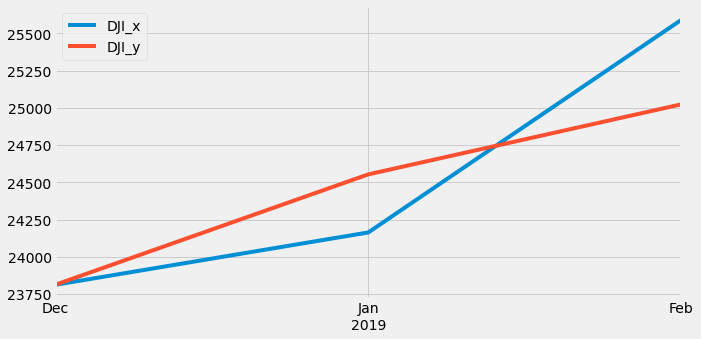

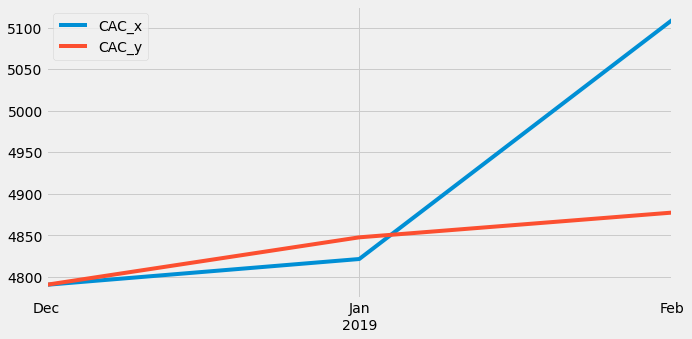

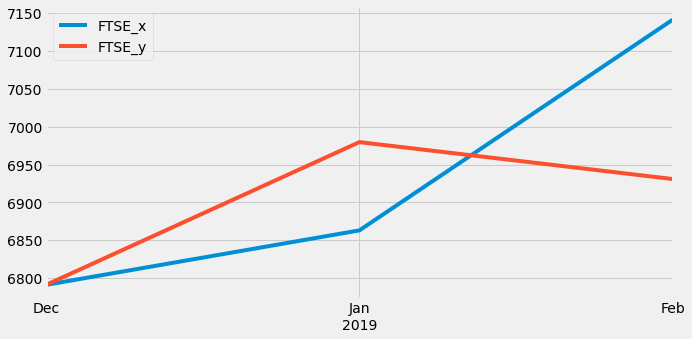

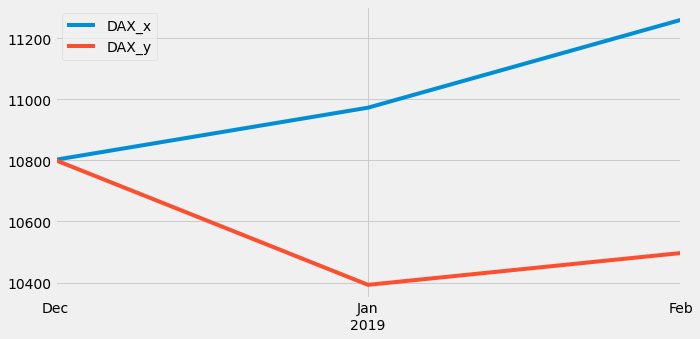

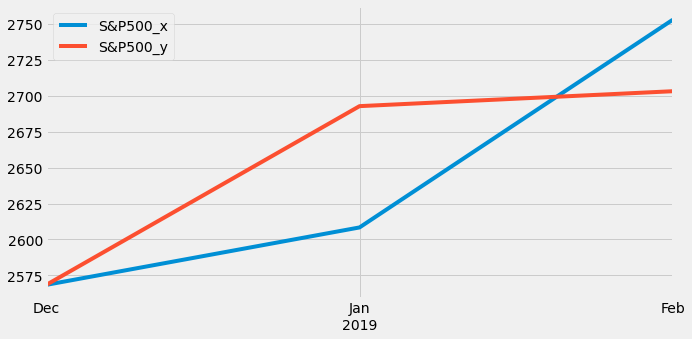

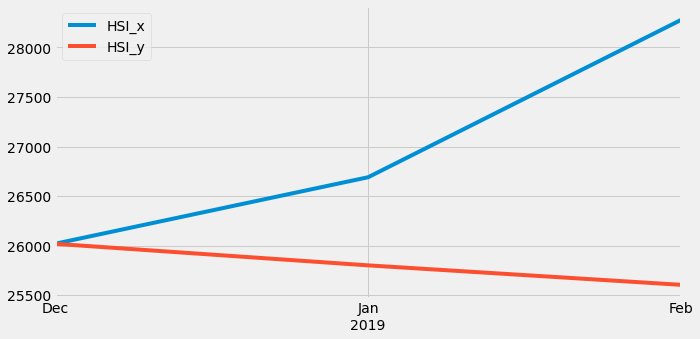

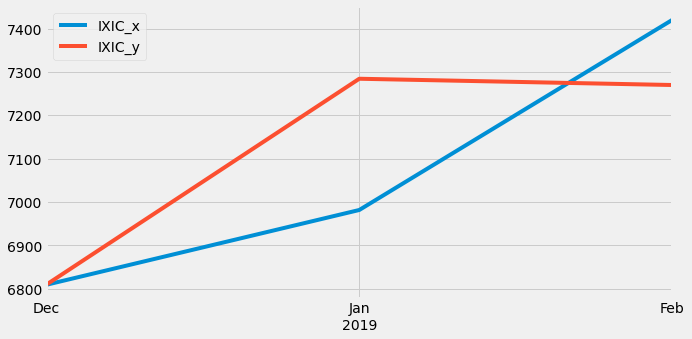

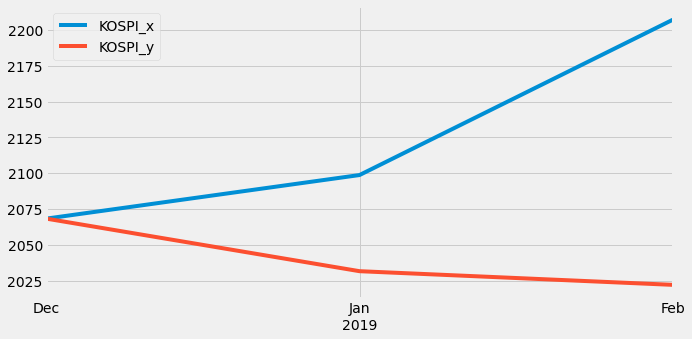

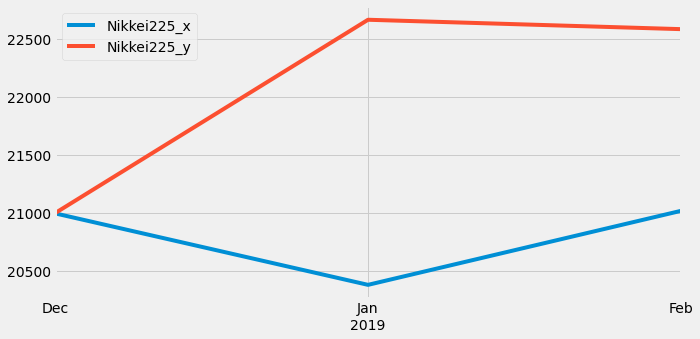

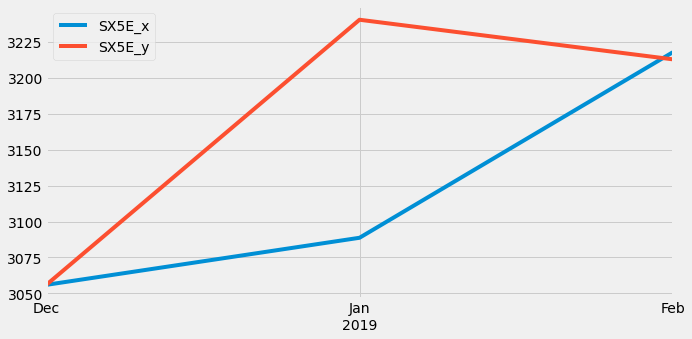

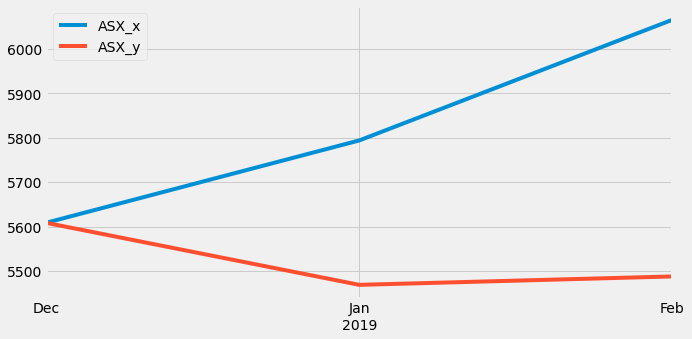

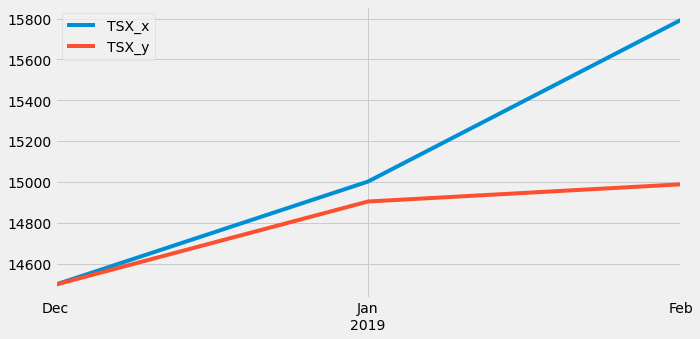

In [105]:
for i in range(1, len(col_names)):
  _ = pd.merge(true_df[col_names[i]], final_df[col_names[i]], how = 'left', left_index = True, right_index=True)
  _ = _.plot(figsize=(10, 5))

In [107]:
final_df = final_df[final_df.index >= '2019-01-01']
final_df

,Coal,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,CAD_dollor,...,FTSE,DAX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E,ASX,TSX
2019-01-01,NaN,68.863810,57.344942,6055.565655,47.838154,47.818584,66.273200,1258.311197,1.403322,1.339620,...,6813.387660,10539.876047,2616.884641,26011.866147,6964.124566,2057.873728,21377.124069,3073.979500,5594.066045,14605.826370
2019-01-02,NaN,69.489232,57.356980,6092.325722,49.080158,49.178786,65.555040,1199.686911,1.374351,1.336147,...,6835.920419,10776.832011,2665.346036,26004.844316,7131.408883,2035.951141,21755.281845,3091.994141,5579.628877,14713.575370
2019-01-03,NaN,70.114654,57.369019,6068.625248,48.075086,48.278661,65.810820,1297.722822,1.398992,1.322301,...,6858.453178,10514.919657,2713.807431,25997.822484,7270.877328,2014.028555,22133.439620,3110.008782,5565.191709,14821.324371
2019-01-04,NaN,70.740077,57.381057,6044.924775,49.317091,49.638862,66.066601,1239.098535,1.366980,1.326405,...,6880.985937,10751.875620,2695.870458,25990.800653,7108.521401,2026.283684,22018.243331,3128.023423,5550.754541,14824.329233
2019-01-05,NaN,71.365499,57.393096,6081.684842,48.312018,48.738737,66.322381,1180.474249,1.389962,1.327558,...,6903.518695,10489.963267,2707.032101,25983.778821,7275.805718,2011.410217,21903.047042,3146.038064,5536.317373,14827.334096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-28,NaN,68.777562,58.380250,6072.983296,49.037939,48.302100,65.869685,1229.748888,1.393111,1.328660,...,6966.986970,10601.118403,2704.637319,24229.291086,7283.158623,2012.572756,22503.217494,3240.478714,5468.133695,15073.732845
2019-03-29,NaN,69.402985,58.392289,6049.282822,48.032867,49.662302,66.125465,1171.124601,1.403152,1.329813,...,6989.519729,10566.079478,2715.798963,24988.797372,7120.802697,2024.827884,22518.571395,3215.879365,5453.696527,15076.737707
2019-03-30,NaN,70.028407,58.404327,6086.042889,49.274872,48.762176,66.381245,1269.160513,1.371140,1.310083,...,6927.089729,10803.035441,2653.854089,24813.390176,7288.087014,2009.954418,22533.925296,3246.384053,5477.730535,15079.742570
2019-03-31,94.670968,70.653830,58.416365,6062.342415,48.269799,47.862051,65.663086,1210.536226,1.395781,1.315955,...,6949.622487,10541.123087,2702.315484,24637.982980,7125.731087,2022.209547,22549.279197,3221.784703,5463.293367,15082.747433


In [108]:
df = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/usethis.csv")
df = df.sort_values('ds')

df['ds']= pd.to_datetime(df['ds'])

df = df.set_index('ds')
df = df[df.index <= '2019-04-01']
 #월요일 기준으로 평균값 df

df = df.reset_index()
# df = df[['ds','Coal_price']]
df  

,ds,Coal,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,...,FTSE,DAX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E,ASX,TSX
0,2011-01-01,122.65,168.30,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,168.30,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,170.00,94.84,9644.00,91.55,91.56,61.07,1773.0,0.97901,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,172.10,93.53,9619.25,89.38,89.23,58.32,1693.0,0.98337,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,174.50,95.50,9586.00,90.30,90.38,56.40,1621.0,0.99285,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008,2019-03-28,92.95,85.64,67.82,6368.75,59.30,59.30,36.05,692.0,1.41153,...,7234.299805,11428.160156,2815.439941,28775.210938,7669.169922,2128.100098,21033.759766,3320.290039,6176.100098,16155.500000
3009,2019-03-29,92.75,85.70,68.39,6475.75,60.14,59.98,34.61,689.0,1.41180,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609
3010,2019-03-30,92.75,85.70,68.39,6475.75,60.14,59.98,34.61,689.0,1.41180,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609
3011,2019-03-31,92.75,85.70,68.39,6475.75,60.14,60.17,34.61,689.0,1.41180,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609


In [109]:

df = df.set_index('ds')
df[df.index >= '2019-01-01']

,Coal,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,CAD_dollor,...,FTSE,DAX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E,ASX,TSX
ds,,,,,,,,,,,,,,,,,,,,,
2019-01-01,102.05,69.20,53.80,5981.00,45.89,45.00,61.07,1271.0,1.42010,1.33943,...,6728.100098,10558.959961,2506.850098,25845.699219,6635.279785,2041.040039,20014.769531,2986.530029,5646.399902,14322.900391
2019-01-02,101.10,71.06,54.91,5871.25,46.54,45.66,62.16,1282.0,1.41886,1.36254,...,6734.200195,10580.190430,2510.030029,25130.349609,6665.939941,2010.000000,20014.769531,2986.530029,5557.799805,14347.200195
2019-01-03,99.60,72.23,55.95,5778.50,47.09,46.78,61.81,1267.0,1.44530,1.36312,...,6692.700195,10416.660156,2447.889893,25064.359375,6463.500000,1993.699951,20014.769531,2954.659912,5633.399902,14212.799805
2019-01-04,99.50,73.09,57.06,5933.75,47.96,48.18,63.55,1260.0,1.42730,1.34788,...,6837.399902,10767.690430,2531.939941,25626.029297,6738.859863,2010.250000,19561.960938,3041.850098,5619.399902,14426.599609
2019-01-05,99.50,73.09,57.06,5933.75,47.96,48.18,63.55,1260.0,1.42730,1.34788,...,6837.399902,10767.690430,2531.939941,25626.029297,6738.859863,2010.250000,19561.960938,3041.850098,5619.399902,14426.599609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-28,92.95,85.64,67.82,6368.75,59.30,59.30,36.05,692.0,1.41153,1.34117,...,7234.299805,11428.160156,2815.439941,28775.210938,7669.169922,2128.100098,21033.759766,3320.290039,6176.100098,16155.500000
2019-03-29,92.75,85.70,68.39,6475.75,60.14,59.98,34.61,689.0,1.41180,1.34305,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609
2019-03-30,92.75,85.70,68.39,6475.75,60.14,59.98,34.61,689.0,1.41180,1.34305,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609


In [110]:
final_df['Coal']=df[df.index >= '2019-01-01']['Coal']
df[df.index >= '2019-01-01']=final_df
df

,Coal,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,CAD_dollor,...,FTSE,DAX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E,ASX,TSX
ds,,,,,,,,,,,,,,,,,,,,,
2011-01-01,122.65,168.300000,94.750000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,0.999600,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2011-01-02,122.65,168.300000,94.750000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,0.999600,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2011-01-03,136.50,170.000000,94.840000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,0.992700,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
2011-01-04,137.30,172.100000,93.530000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,0.992390,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
2011-01-05,130.65,174.500000,95.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,0.997000,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-28,92.95,68.777562,58.380250,6072.983296,49.037939,48.302100,65.869685,1229.748888,1.393111,1.328660,...,6966.986970,10601.118403,2704.637319,24229.291086,7283.158623,2012.572756,22503.217494,3240.478714,5468.133695,15073.732845
2019-03-29,92.75,69.402985,58.392289,6049.282822,48.032867,49.662302,66.125465,1171.124601,1.403152,1.329813,...,6989.519729,10566.079478,2715.798963,24988.797372,7120.802697,2024.827884,22518.571395,3215.879365,5453.696527,15076.737707
2019-03-30,92.75,70.028407,58.404327,6086.042889,49.274872,48.762176,66.381245,1269.160513,1.371140,1.310083,...,6927.089729,10803.035441,2653.854089,24813.390176,7288.087014,2009.954418,22533.925296,3246.384053,5477.730535,15079.742570


In [111]:
df.to_csv("/content/gdrive/MyDrive/Black_coal/data/XGB_Month_pred.csv",encoding = 'utf-8-sig',index= True)

In [112]:
df = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/XGB_Month_pred.csv")

In [113]:
df

,ds,Coal,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,...,FTSE,DAX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E,ASX,TSX
0,2011-01-01,122.65,168.300000,94.750000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,168.300000,94.750000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,170.000000,94.840000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,172.100000,93.530000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,174.500000,95.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008,2019-03-28,92.95,68.777562,58.380250,6072.983296,49.037939,48.302100,65.869685,1229.748888,1.393111,...,6966.986970,10601.118403,2704.637319,24229.291086,7283.158623,2012.572756,22503.217494,3240.478714,5468.133695,15073.732845
3009,2019-03-29,92.75,69.402985,58.392289,6049.282822,48.032867,49.662302,66.125465,1171.124601,1.403152,...,6989.519729,10566.079478,2715.798963,24988.797372,7120.802697,2024.827884,22518.571395,3215.879365,5453.696527,15076.737707
3010,2019-03-30,92.75,70.028407,58.404327,6086.042889,49.274872,48.762176,66.381245,1269.160513,1.371140,...,6927.089729,10803.035441,2653.854089,24813.390176,7288.087014,2009.954418,22533.925296,3246.384053,5477.730535,15079.742570
3011,2019-03-31,92.75,70.653830,58.416365,6062.342415,48.269799,47.862051,65.663086,1210.536226,1.395781,...,6949.622487,10541.123087,2702.315484,24637.982980,7125.731087,2022.209547,22549.279197,3221.784703,5463.293367,15082.747433


#4.Heatmap

In [ ]:
df_heat = df.set_index('ds')

In [ ]:
df

,ds,Coal_price,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,168.30,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,168.30,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,170.00,94.84,9644.00,91.55,91.56,61.07,1773.0,0.97901,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,172.10,93.53,9619.25,89.38,89.23,58.32,1693.0,0.98337,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,174.50,95.50,9586.00,90.30,90.38,56.40,1621.0,0.99285,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,93.50,85.72,67.83,6336.00,59.41,59.12,37.47,690.0,1.40115,...,7194.200195,11419.040039,2805.370117,28728.250000,7643.379883,2145.620117,21378.730469,3322.040039,6136.000000,16132.500000
3008,2019-03-28,92.95,85.64,67.82,6368.75,59.30,59.30,36.05,692.0,1.41153,...,7234.299805,11428.160156,2815.439941,28775.210938,7669.169922,2128.100098,21033.759766,3320.290039,6176.100098,16155.500000
3009,2019-03-29,92.75,85.70,68.39,6475.75,60.14,59.98,34.61,689.0,1.41180,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609
3010,2019-03-30,92.75,85.70,68.39,6475.75,60.14,59.98,34.61,689.0,1.41180,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609


In [ ]:

df= df[['Coal_price', 'iron', 'Brent_fut', 'WTI_fut', 'WTI', 
        'LNG_fut', 'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'USD/IDR(인도네시아)', 
        'USD/RUB(러시아)', 'USD/ZAR(자메이카)', 'US 달러지수', '상하이종합지수', '인도지수', '브라질지수', 
        '다우존스지수', '프랑스지수', '영국지수', '독일지수', '호주지수', '캐나다지수', 
        'S&P500지수', '항셍지수', '나스닥지수', '코스피지수', '니케이225지수', '유로스톡스50지수']]
df.columns = ['Coal', 'Iron', 'Brent_fut', 'WTI_fut', 'WTI', 
              'LNG_fut', 'BDI', 'AUD_dollar', 'CAD_dollor', 'COP_dollor', 'IDR_dollor', 
              'RUB_dollor', 'ZAR_dollor', 'DXY' , 'SHA', 'BSE', 'BVSP', 
              'DJI', 'CAC', 'FTSE', 'DAX', 'ASX', 'TSX', 
              'S&P500', 'HSI', 'IXIC', 'KOSPI', 'Nikkei225', 'SX5E']
df.head()

,Coal,Iron,Brent_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,CAD_dollor,COP_dollor,...,FTSE,DAX,ASX,TSX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E
0,122.65,168.3,94.75,91.38,91.40,61.07,1773.0,0.98447,0.99960,1915.0,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
1,122.65,168.3,94.75,91.38,91.40,61.07,1773.0,0.98447,0.99960,1915.0,...,5899.899902,6914.189941,4745.200195,13443.200195,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039
2,136.50,170.0,94.84,91.55,91.56,61.07,1773.0,0.97901,0.99270,1892.0,...,5899.899902,6989.740234,4745.200195,13443.200195,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932
3,137.30,172.1,93.53,89.38,89.23,58.32,1693.0,0.98337,0.99239,1896.5,...,6013.899902,6975.350098,4742.500000,13402.299805,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922
4,130.65,174.5,95.50,90.30,90.38,56.40,1621.0,0.99285,0.99700,1884.0,...,6043.899902,6939.819824,4714.899902,13396.000000,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990


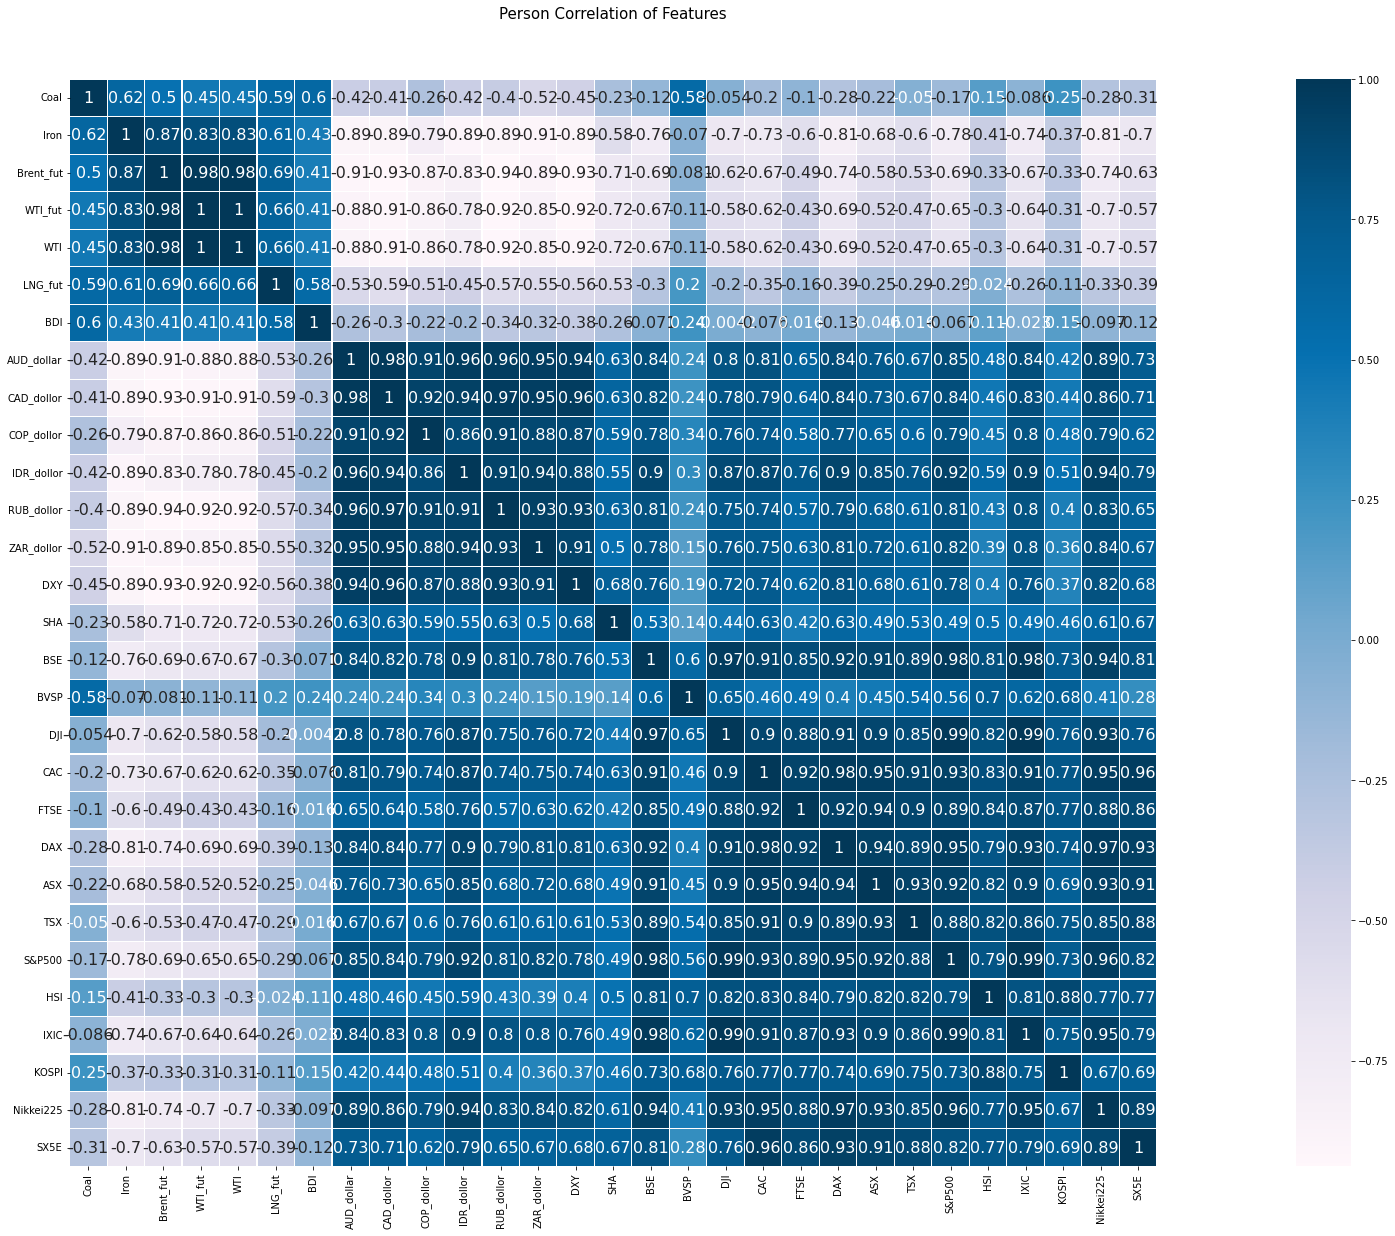

In [ ]:
colormap = plt.cm.PuBu
plt.figure(figsize=(50, 20))
plt.title("Person Correlation of Features", y = 1.05, size = 15)
sns.heatmap(df.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})
